In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import time
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryFocalCrossentropy

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data = data.dropna()  
    return data

def prepare_features_and_labels(data):
    features = ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric', 'Towers', 'LPS', 'Oil_level', 'Caudal_impulses']
    target = 'class'
    X = data[features].values
    y = data[target].values
    return X, y


In [ ]:

def balance_and_sample(X, y, sample_fraction=0.4):
    X, y = shuffle(X, y, random_state=42)
    sample_size = int(sample_fraction * len(X))
    X_sample, y_sample = X[:sample_size], y[:sample_size]
    
    classes = np.unique(y_sample)
    max_samples = max([np.sum(y_sample == cls) for cls in classes])
    
    X_balanced = []
    y_balanced = []
    
    for cls in classes:
        X_cls = X_sample[y_sample == cls]
        y_cls = y_sample[y_sample == cls]
        
        X_balanced.append(X_cls[:max_samples])
        y_balanced.append(y_cls[:max_samples])
    
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.hstack(y_balanced)
    
    return X_balanced, y_balanced

def preprocess_data(data):
    if 'timestamp' not in data.columns or 'class' not in data.columns:
        raise ValueError("Data must contain 'timestamp' and 'class' columns.")
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data = data.dropna(subset=['timestamp'])
    data['month'] = data['timestamp'].dt.to_period('M')
    months = data['month'].astype(str).unique()
    
    if len(months) < 4:
        raise ValueError("Not enough distinct months to split into global and client data.")
    
    months.sort()
    first_two_months = months[:2]
    last_two_months = months[-2:]
    
    global_data = data[data['month'].astype(str).isin(first_two_months)]
    client1_data = data[data['month'].astype(str) == last_two_months[0]]
    client2_data = data[data['month'].astype(str) == last_two_months[1]]
    
    if global_data.empty or client1_data.empty or client2_data.empty:
        raise ValueError("One or more of the filtered datasets are empty.")
    
    return global_data, client1_data, client2_data

In [ ]:

'''def create_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = GRU(32)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
 '''


def create_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=BinaryFocalCrossentropy(gamma=2.0), metrics=['accuracy'])
    
    return model

def measure_communication_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

In [12]:

def federated_learning(global_data, client1_data, client2_data):
    print("Preparing global data...")
    X_global, y_global = prepare_features_and_labels(global_data)
    X_global, y_global = balance_and_sample(X_global, y_global, sample_fraction=0.4)
    
    print("Preparing client data...")
    X_client1, y_client1 = prepare_features_and_labels(client1_data)
    X_client2, y_client2 = prepare_features_and_labels(client2_data)
    X_client1, y_client1 = balance_and_sample(X_client1, y_client1, sample_fraction=0.4)
    X_client2, y_client2 = balance_and_sample(X_client2, y_client2, sample_fraction=0.4)
    
    X_global = X_global[:, np.newaxis, :]
    X_client1 = X_client1[:, np.newaxis, :]
    X_client2 = X_client2[:, np.newaxis, :]
    
    print("Creating and training global model...")
    model = create_gru_model(input_shape=(X_global.shape[1], X_global.shape[2]))
    _, train_time_global = measure_communication_time(model.fit, X_global, y_global, epochs=10, batch_size=32, verbose=2)
    print(f"Time to train global model: {train_time_global:.2f} seconds.")
    
    client_data = [
        (X_client1, y_client1, "Client 1"),
        (X_client2, y_client2, "Client 2")
    ]
    
    print("Fine-tuning model on client data...")
    for X_client, y_client, client_name in tqdm(client_data, desc="Clients", unit="client"):
        print(f"Fine-tuning on {client_name}...")
        
        def train_func():
            model.fit(X_client, y_client, epochs=5, batch_size=32, verbose=2)
        
        _, update_time = measure_communication_time(train_func)
        print(f"Time to fine-tune on {client_name}: {update_time:.2f} seconds.")
    
    print("Evaluating the updated global model...")
    y_global_pred = (model.predict(X_global) > 0.5).astype(int)
    print("Model Classification Report:")
    print(classification_report(y_global, y_global_pred))
    print("Model Accuracy Score:", accuracy_score(y_global, y_global_pred))
    
    print("Federated learning completed.")
    return train_time_global, update_time

file_path = 'Metro-Both-Classes.csv'
data = load_and_preprocess_data(file_path)
global_data, client1_data, client2_data = preprocess_data(data)
train_time_global_no_compression, update_time_no_compression = federated_learning(global_data, client1_data, client2_data)


Preparing global data...
Preparing client data...
Creating and training global model...
Epoch 1/10
5145/5145 - 27s - 5ms/step - accuracy: 0.9729 - loss: 0.0144
Epoch 2/10
5145/5145 - 20s - 4ms/step - accuracy: 0.9733 - loss: 0.0130
Epoch 3/10
5145/5145 - 17s - 3ms/step - accuracy: 0.9750 - loss: 0.0123
Epoch 4/10
5145/5145 - 16s - 3ms/step - accuracy: 0.9827 - loss: 0.0098
Epoch 5/10
5145/5145 - 16s - 3ms/step - accuracy: 0.9813 - loss: 0.0105
Epoch 6/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9909 - loss: 0.0068
Epoch 7/10
5145/5145 - 19s - 4ms/step - accuracy: 0.9901 - loss: 0.0071
Epoch 8/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9925 - loss: 0.0060
Epoch 9/10
5145/5145 - 17s - 3ms/step - accuracy: 0.9930 - loss: 0.0059
Epoch 10/10
5145/5145 - 17s - 3ms/step - accuracy: 0.9932 - loss: 0.0057
Time to train global model: 185.11 seconds.
Fine-tuning model on client data...


Clients:   0%|          | 0/2 [00:00<?, ?client/s]

Fine-tuning on Client 1...
Epoch 1/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9970 - loss: 0.0031
Epoch 2/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9970 - loss: 0.0027
Epoch 3/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9975 - loss: 0.0023
Epoch 4/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9973 - loss: 0.0023
Epoch 5/5
2707/2707 - 9s - 3ms/step - accuracy: 0.9975 - loss: 0.0022


Clients:  50%|█████     | 1/2 [00:45<00:45, 45.22s/client]

Time to fine-tune on Client 1: 45.22 seconds.
Fine-tuning on Client 2...
Epoch 1/5
2783/2783 - 14s - 5ms/step - accuracy: 0.9948 - loss: 0.0042
Epoch 2/5
2783/2783 - 13s - 5ms/step - accuracy: 0.9973 - loss: 0.0026
Epoch 3/5
2783/2783 - 13s - 5ms/step - accuracy: 0.9982 - loss: 0.0020
Epoch 4/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9983 - loss: 0.0019
Epoch 5/5
2783/2783 - 13s - 5ms/step - accuracy: 0.9982 - loss: 0.0018


Clients: 100%|██████████| 2/2 [01:49<00:00, 54.55s/client]

Time to fine-tune on Client 2: 63.88 seconds.
Evaluating the updated global model...


5145/5145 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    160227
           1       0.00      0.00      0.00      4386

    accuracy                           0.97    164613
   macro avg       0.49      0.50      0.49    164613
weighted avg       0.95      0.97      0.96    164613

Model Accuracy Score: 0.973203817438477
Federated learning completed.


In [ ]:
def compress_gradients_sparsification(gradients, threshold=0.1):
    compressed_gradients = []
    for grad in gradients:
        mask = tf.abs(grad) > threshold
        compressed_gradients.append(tf.multiply(grad, tf.cast(mask, grad.dtype)))
    return compressed_gradients


In [13]:

def federated_learning_with_compression(global_data, client1_data, client2_data):
    print("Preparing global data...")
    X_global, y_global = prepare_features_and_labels(global_data)
    X_global, y_global = balance_and_sample(X_global, y_global, sample_fraction=0.4)
    
    print("Preparing client data...")
    X_client1, y_client1 = prepare_features_and_labels(client1_data)
    X_client2, y_client2 = prepare_features_and_labels(client2_data)
    X_client1, y_client1 = balance_and_sample(X_client1, y_client1, sample_fraction=0.4)
    X_client2, y_client2 = balance_and_sample(X_client2, y_client2, sample_fraction=0.4)
    
    X_global = X_global[:, np.newaxis, :]
    X_client1 = X_client1[:, np.newaxis, :]
    X_client2 = X_client2[:, np.newaxis, :]
    
    print("Creating and training global model...")
    model = create_gru_model(input_shape=(X_global.shape[1], X_global.shape[2]))
    _, train_time_global = measure_communication_time(model.fit, X_global, y_global, epochs=10, batch_size=32, verbose=2)
    print(f"Time to train global model: {train_time_global:.2f} seconds.")
    
    client_data = [
        (X_client1, y_client1, "Client 1"),
        (X_client2, y_client2, "Client 2")
    ]
    
    print("Fine-tuning model on client data with gradient compression...")
    for X_client, y_client, client_name in tqdm(client_data, desc="Clients", unit="client"):
        print(f"Fine-tuning on {client_name} with gradient compression...")
        
        def train_func():
            model.fit(X_client, y_client, epochs=5, batch_size=32, verbose=2)
        
        _, update_time = measure_communication_time(train_func)
        print(f"Time to fine-tune on {client_name}: {update_time:.2f} seconds.")
        
        with tf.GradientTape() as tape:
            logits = model(X_client, training=True)
            y_client = tf.reshape(y_client, (-1, 1))
            loss = tf.keras.losses.binary_crossentropy(y_client, logits)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        compressed_gradients = compress_gradients_sparsification(gradients)
        print(f"Compressed gradients size for {client_name}: {sum([tf.size(g).numpy() for g in compressed_gradients])}")
        
        model.optimizer.apply_gradients(zip(compressed_gradients, model.trainable_variables))
    
    print("Evaluating the updated global model...")
    y_global_pred = (model.predict(X_global) > 0.5).astype(int)
    print("Model Classification Report:")
    print(classification_report(y_global, y_global_pred))
    print("Model Accuracy Score:", accuracy_score(y_global, y_global_pred))
    
    print("Federated learning with gradient compression completed.")
    return train_time_global, update_time

train_time_global_compression, update_time_compression = federated_learning_with_compression(global_data, client1_data, client2_data)


Preparing global data...
Preparing client data...
Creating and training global model...
Epoch 1/10
5145/5145 - 27s - 5ms/step - accuracy: 0.9731 - loss: 0.0143
Epoch 2/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9733 - loss: 0.0132
Epoch 3/10
5145/5145 - 21s - 4ms/step - accuracy: 0.9734 - loss: 0.0129
Epoch 4/10
5145/5145 - 20s - 4ms/step - accuracy: 0.9832 - loss: 0.0097
Epoch 5/10
5145/5145 - 20s - 4ms/step - accuracy: 0.9902 - loss: 0.0073
Epoch 6/10
5145/5145 - 18s - 3ms/step - accuracy: 0.9903 - loss: 0.0072
Epoch 7/10
5145/5145 - 20s - 4ms/step - accuracy: 0.9927 - loss: 0.0062
Epoch 8/10
5145/5145 - 18s - 4ms/step - accuracy: 0.9917 - loss: 0.0064
Epoch 9/10
5145/5145 - 21s - 4ms/step - accuracy: 0.9929 - loss: 0.0059
Epoch 10/10
5145/5145 - 21s - 4ms/step - accuracy: 0.9937 - loss: 0.0055
Time to train global model: 204.46 seconds.
Fine-tuning model on client data with gradient compression...


Clients:   0%|          | 0/2 [00:00<?, ?client/s]

Fine-tuning on Client 1 with gradient compression...
Epoch 1/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9968 - loss: 0.0033
Epoch 2/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9973 - loss: 0.0026
Epoch 3/5
2707/2707 - 10s - 4ms/step - accuracy: 0.9973 - loss: 0.0024
Epoch 4/5
2707/2707 - 11s - 4ms/step - accuracy: 0.9976 - loss: 0.0023
Epoch 5/5
2707/2707 - 19s - 7ms/step - accuracy: 0.9984 - loss: 0.0017
Time to fine-tune on Client 1: 60.48 seconds.
Compressed gradients size for Client 1: 102209


Clients:  50%|█████     | 1/2 [01:06<01:06, 66.71s/client]

Fine-tuning on Client 2 with gradient compression...
Epoch 1/5
2783/2783 - 12s - 4ms/step - accuracy: 0.9917 - loss: 0.0191
Epoch 2/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9943 - loss: 0.0042
Epoch 3/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9964 - loss: 0.0030
Epoch 4/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9968 - loss: 0.0028
Epoch 5/5
2783/2783 - 10s - 4ms/step - accuracy: 0.9971 - loss: 0.0026
Time to fine-tune on Client 2: 52.62 seconds.


Clients: 100%|██████████| 2/2 [02:04<00:00, 62.14s/client]

Compressed gradients size for Client 2: 102209
Evaluating the updated global model...


5145/5145 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    160227
           1       0.62      0.03      0.05      4386

    accuracy                           0.97    164613
   macro avg       0.80      0.51      0.52    164613
weighted avg       0.96      0.97      0.96    164613

Model Accuracy Score: 0.9736229823889972
Federated learning with gradient compression completed.


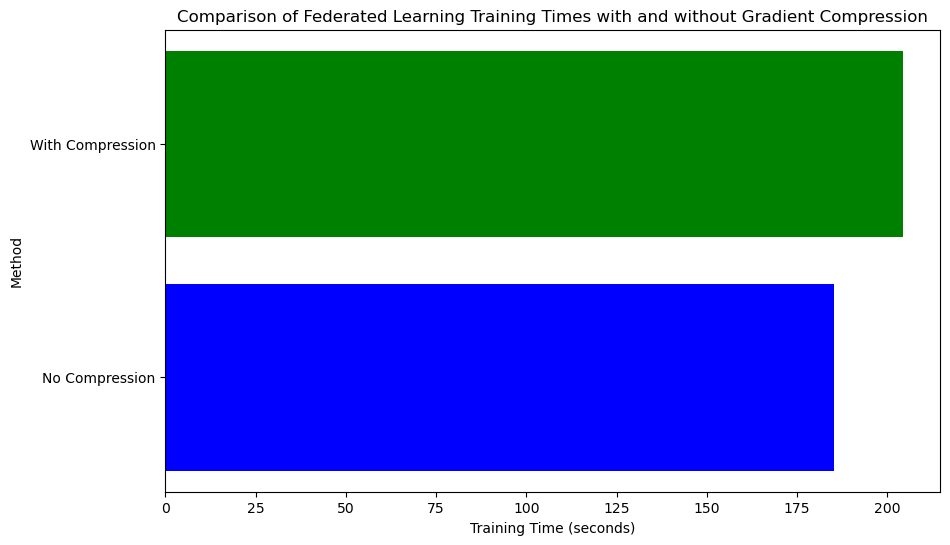

In [14]:
methods = ["No Compression", "With Compression"]
train_times = [train_time_global_no_compression, train_time_global_compression]
update_times = [update_time_no_compression, update_time_compression]

plt.figure(figsize=(10, 6))
plt.barh(methods, train_times, color=['blue', 'green'])
plt.xlabel("Training Time (seconds)")
plt.ylabel("Method")
plt.title("Comparison of Federated Learning Training Times with and without Gradient Compression")
plt.show()

